## Predict Future Sales (1/2)
このkernelは[Feature engineering, xgboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)を参考に日本語で整理してまとめています。  
作成しながら構成の整理等は行なっていきたいと思います。誤った箇所などありましたらご指摘お願いします。

In [1]:
import pandas as pd
import numpy as np

In [4]:
# データの読み込み
train = pd.read_csv('./input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('./input/competitive-data-science-predict-future-sales/test.csv')

In [5]:
# データサイズの確認
print(train.shape)
print(test.shape)

(2935849, 6)
(214200, 3)


# 2013年1月から2015年10月までの日次履歴データ

## 各カラムの意味

```
# date:日付(表示形式:日.月.年っぽい)
# date_block_num:年月ごとの連番
# shop_id:店ID
# item_id:アイテムID
# item_price:商品価格
# item_cnt_day:その日に販売された製品の数
```

In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
train.columns = ['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


# 2015年11月のショップIDとアイテムIDの売上を予測していく
## 各カラムの意味

```
# ID:インデックス
# shop_id:店ID
# item_id:アイテムID
```

In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# shop.csvの確認

## 各カラムの意味

```
# shop_name:店名
# shop_id:店ID
```

In [11]:
shops = pd.read_csv('./input/competitive-data-science-predict-future-sales/shops.csv');
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# item.csvの確認

## 各カラムの意味

```
# item_name:商品名
# item_id:商品ID
# item_category_id:商品カテゴリID
```

In [13]:
items= pd.read_csv('./input/competitive-data-science-predict-future-sales/items.csv');
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


# item_categories.csvの確認

## 各カラムの意味

```
# item_category_name:商品カテゴリ名
# item_category_id:商品カテゴリID
```

In [14]:
# item_categories.csvの確認
cats= pd.read_csv('./input/competitive-data-science-predict-future-sales/item_categories.csv');
print(cats.shape)
cats.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [15]:
# sample_submission.csvの確認
sample_submission= pd.read_csv('./input/competitive-data-science-predict-future-sales/sample_submission.csv');
print(sample_submission.shape)
# 各カラムの意味
# ID:インデックス(test.csvに紐づく)
# item_cnt_month:その月に販売された製品の数
sample_submission.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## 外れ値の確認/除外

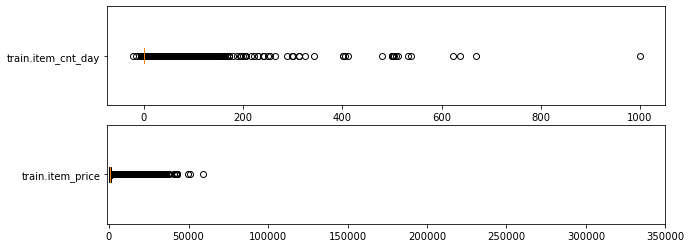

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# trainデータにて、「製品の個数」を箱ひげ図で確認する
fig,ax = plt.subplots(2,1,figsize=(10,4))
# 尺度の調整
plt.xlim(-300, 3000)
# 箱ひげ図を描画
ax[0].boxplot((train.item_cnt_day) , labels=['train.item_cnt_day'], vert=False)

# trainデータにて、「商品の価格」を箱ひげ図で確認する
plt.xlim(-1000, 350000)
ax[1].boxplot((train.item_price) , labels=['train.item_price'], vert=False)
plt.show()

上記の箱ひげ図より、各データで外れ値が存在していることが確認できました。  
train.item_price>100000 および >1001 の外れ値を訓練データから削除します。

In [17]:
# 外れ値の除外
train = train[train.item_cnt_day<1001]
train = train[train.item_price<100000]

train.item_priceにて0以下の値が誤って存在しています。

## 誤って登録されたゴミデータの確認/修正

In [19]:
# 0以下の値
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


同じ年月/店ID/商品IDの中央値をこの誤った値に代入します。

In [20]:
# 同じ年月/店ID/商品IDの中央値を median に代入
median = train[(train.date_block_num==4)&(train.shop_id==32)&(train.item_id==2973)&(train.item_price>0)].item_price.median()
# median を0以下の値に代入
train.loc[train.item_price<0, 'item_price'] = median
# 代入されたため、train.item_priceにて0以下の値が存在しないことを確認
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


次に、店情報を確認すると異なる店IDで同じ店名(厳密には等しく無い)が誤って登録されていることが確認できます。  
(これはロシア後読めないと絶対に気づけない前処理ですね笑)

In [22]:
# 店情報を確認(全部で60店しかありません)
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [23]:
# 重複していた店名のIDを統一させます。(train/test両方で処理しておきます)
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shop/Cat/Itemの前処理

上記のshopデータなどの観察から以下のことがわかります。
- 店名(shop_name)は、ロシアの各都市名で始まっています。
 - shop_nameの構成は [都市名 店のタイプ "店名"]など 必ず都市名で始まっている

上記でshopデータを全件確認しているので、データ確認は省きます。  
shopsデータから確認前処理していきましょう。

In [24]:
from sklearn.preprocessing import LabelEncoder
# Сергиев Посад = セルギエフ・ポサドがスペースで空いてしまっているので、このスペースを埋めます。
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
# shop_nameの先頭を抽出してshopに新たな列[city(都市)]を追加します
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
# 都市名の先頭に[!]がゴミ(タイポらしい)として入ってしまっているので、これを修正する
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
# LabelEncoderを使って数値化します。
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
# shopsの構造を['shop_id', 'city_code']に設定する
shops = shops[['shop_id','city_code']]

In [25]:
# 前処理後こんな感じになります
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


次に、catsですが、改めて全件確認してみましょう。

In [26]:
cats

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


catsの観察で以下の点に気づけます。
- カテゴリ名は、[タイプ-サブタイプ]の構成となっている  

そのためcatsのカテゴリ名から、タイプ/サブタイプの列を追加していきましょう。

In [27]:
# '-'でカテゴリ名を分割します
cats['split'] = cats['item_category_name'].str.split('-')
# typeには-で分割した先頭の値を代入します
cats['type'] = cats['split'].map(lambda x: x[0].strip())
# 中にはサブタイプを持たないデータもあるので、その場合はsubtypeにタイプを代入します
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
# LabelEncoderを使って数値化します。
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
# shopsの構造を['item_category_id', 'type_code', 'subtype_code']に設定する
cats = cats[['item_category_id','type_code', 'subtype_code']]

In [28]:
# 前処理後こんな感じになります
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


次に、itemsを観察してみましょう

In [29]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


item_nameには特徴量となりそうな情報がないので列ごと抹殺してやりましょう。

In [30]:
items.drop(['item_name'], axis=1, inplace=True)

In [31]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


抹殺されて、item_idとitem_category_idのみになっていることが確認できます。

## 月次売上

test.csvは2015年11月の月次売上を求めるために商品ID/店IDの組み合わせから構成されています。   
その組み合わせの数は 商品数(5100) * 店数(42) = 214200ペアあります。  
testに存在して、trainに存在しない商品は363個あります。  
したがって、これらの商品に対しての目的変数(今回は月次売上)は予測できないので、0でなければなりません。  
一方、trainデータが含む全ての商品は過去に売られている(または返品)ペアのみです。
今回の主となる方針では、月次売上を計算し、そのペアごとに売上を0に拡張していきます。(?)

In [32]:
# test(item_id) - (test(item_id) 積集合 train(item_id)) = trainに存在しないtestの商品IDの数
print(len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))))
# testの商品IDの数(重複は除く)
print(len(list(set(test.item_id))))
# testの総数
print(len(test))

363
5100
214200


In [33]:
# train.date_block_numにて、列(Series型)ごとにユニークな値を確認(年月の組み合わせは33パターンと確認できる)
train.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [43]:
import time
# 複数のリストの直積（デカルト積）を生成するためのライブラリ
from itertools import product
ts = time.time()

# 訓練データに存在する、(年月番号,店ID,商品ID)の全組み合わせを列挙した行列を生成していく
# 最終的にmatrixを学習モデルの訓練データとする
matrix = []
for i in range(34):
    # 変数salesにdate_block_num=iの行列(表)データを代入する
    sales = train[train.date_block_num==i]
    # trainデータに存在する、(年月番号,店ID,商品ID)の全組み合わせを列挙した行列を追加していく
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

# 列名を改めて設定してmatrixを更新
cols = ['date_block_num','shop_id','item_id']
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# .astype(~~~):各特徴量を~~~でキャスト
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
# colsをソート対象とする、inplace=Trueでオブジェクトをそのまま更新
matrix.sort_values(cols,inplace=True)
time.time() - ts
# 20.83844780921936

5.860445261001587

In [44]:
matrix.shape

(10913804, 3)

In [45]:
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [46]:
# trainデータに revenue(その日の収支合計) を追加します
train['revenue'] = train['item_price'] *  train['item_cnt_day']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [47]:
# trainデータにて、'date_block_num','shop_id','item_id'でGROUP化したDataFrameGroupByオブジェクトに対して、'item_cnt_day'を集計します
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
# 列名の更新
group.columns = ['item_cnt_month']
# DataFrameGroupBy -> DataFrame に変換
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [48]:
# DataFrame同士でcolsを条件に左結合する
matrix = pd.merge(matrix, group, on=cols, how='left')
# item_cnt_monthの前処理
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0) # 0で穴埋めする
                                .clip(0,20) # 最小値0/最大値20に収める(なぜこの値？)
                                .astype(np.float16)) # 型のキャスト
matrix.shape

(10913804, 4)

## テストデータ(前処理を行う)

In [49]:
 # 2015年11月のデータのためdate_block_num = 34として列を追加してあげましょう
test['date_block_num'] = 34
# 型のキャスト
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [35]:
test.shape

(214200, 4)

In [50]:
ts = time.time()
# matrixにtestを連結させる
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
# NaNを0に変換
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts
matrix[matrix.date_block_num==34]

,date_block_num,shop_id,item_id,item_cnt_month,ID
10913804,34,5,5037,0.0,0.0
10913805,34,5,5320,0.0,1.0
10913806,34,5,5233,0.0,2.0
10913807,34,5,5232,0.0,3.0
10913808,34,5,5268,0.0,4.0
...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0
11128000,34,45,16188,0.0,214196.0
11128001,34,45,15757,0.0,214197.0
11128002,34,45,19648,0.0,214198.0


## Shop/Cat/Itemの特徴量

In [51]:
ts = time.time()
# Shop/Cat/Itemの特徴量をmatrixに追加する
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
# 型のキャスト
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0.0,0,40,11,4
1,0,2,27,1.0,0.0,0,19,5,10
2,0,2,28,0.0,0.0,0,30,8,55
3,0,2,29,0.0,0.0,0,23,5,16
4,0,2,32,0.0,0.0,0,40,11,4
...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2
11128000,34,45,16188,0.0,214196.0,20,64,14,42
11128001,34,45,15757,0.0,214197.0,20,55,13,2
11128002,34,45,19648,0.0,214198.0,20,40,11,4


## 目的変数のラグ

In [52]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        # 列名の更新
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [54]:
ts = time.time()
# [1,2,3,6,12]に格納された値のヶ月前のitem_cnt_monthを特量量として追加する
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

13.505089044570923

In [55]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,0.0,0.0,0.0,NaN


## Mean encoded features

### date_block_num で絞った 月次売上個数のlag

In [58]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
group

,date_block_num,date_avg_item_cnt
0,0,0.347168
1,1,0.324463
2,2,0.355469
3,3,0.275391
4,4,0.265137
5,5,0.283203
6,6,0.276855
7,7,0.316650
8,8,0.308105
9,9,0.290039


In [59]:
ts = time.time()
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

4.5199480056762695

In [60]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN,0.258545
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN,0.258545
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.258545
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,0.0,0.0,0.0,NaN,0.258545


### date_block_numとItem_id で絞った 月次売上個数 のlag

In [61]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)
group

,date_block_num,item_id,date_item_avg_item_cnt
0,0,19,0.022217
1,0,27,0.155518
2,0,28,0.177734
3,0,29,0.088867
4,0,32,5.378906
...,...,...,...
239006,34,22162,0.000000
239007,34,22163,0.000000
239008,34,22164,0.000000
239009,34,22166,0.000000


In [62]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

27.122194051742554

In [63]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12
0,0,2,19,0.0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN,0.258545,0.045441,0.023254,0.071411,0.590820,NaN
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN,0.258545,0.022720,0.069763,NaN,NaN,NaN
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.258545,0.113647,0.069763,0.095215,0.250000,0.180054
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,0.0,0.0,0.0,NaN,0.258545,0.045441,0.069763,0.166626,0.090881,NaN


### date_block_numとshop_id で絞った 月次売上個数 のlag

In [64]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)
group

,date_block_num,shop_id,date_shop_avg_item_cnt
0,0,2,0.141235
1,0,3,0.094543
2,0,4,0.257324
3,0,6,0.438721
4,0,7,0.305908
...,...,...,...
1623,34,55,0.000000
1624,34,56,0.000000
1625,34,57,0.000000
1626,34,58,0.000000


In [65]:
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.045441,0.023254,0.071411,0.590820,NaN,0.126709,0.128784,0.139038,0.137573,NaN
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.022720,0.069763,NaN,NaN,NaN,0.126709,0.128784,NaN,NaN,NaN
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.113647,0.069763,0.095215,0.250000,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.045441,0.069763,0.166626,0.090881,NaN,0.126709,0.128784,0.139038,0.137573,NaN


### date_block_numとitem_category_id で絞った 月次売上個数 のlag

In [66]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)
group

,date_block_num,item_category_id,date_cat_avg_item_cnt
0,0,0,0.022217
1,0,1,0.022217
2,0,2,0.835449
3,0,3,4.421875
4,0,4,0.513184
...,...,...,...
2134,34,76,0.000000
2135,34,77,0.000000
2136,34,78,0.000000
2137,34,79,0.000000


In [67]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.023254,0.071411,0.590820,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.196899
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.069763,NaN,NaN,NaN,0.126709,0.128784,NaN,NaN,NaN,0.155884
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.069763,0.095215,0.250000,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274,0.196899
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.069763,0.166626,0.090881,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.220825


### date_block_numと 'shop_id', 'item_category_id' で絞った 月次売上個数 のlag

In [68]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)
group

,date_block_num,shop_id,item_category_id,date_shop_cat_avg_item_cnt
0,0,2,0,0.000000
1,0,2,1,0.000000
2,0,2,2,0.675781
3,0,2,3,4.500000
4,0,2,4,0.909180
...,...,...,...,...
99525,34,59,76,0.000000
99526,34,59,77,0.000000
99527,34,59,78,0.000000
99528,34,59,79,0.000000


In [69]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.071411,0.590820,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.196899,0.126831
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,NaN,NaN,NaN,0.126709,0.128784,NaN,NaN,NaN,0.155884,0.094482
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.095215,0.250000,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274,0.196899,0.126831
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.166626,0.090881,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.220825,0.083740


### date_block_numと 'shop_id', 'type_code' で絞った 月次売上個数 のlag

In [70]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)
group

,date_block_num,shop_id,type_code,date_shop_type_avg_item_cnt
0,0,2,0,0.000000
1,0,2,1,0.680176
2,0,2,3,0.000000
3,0,2,4,0.444336
4,0,2,5,0.427002
...,...,...,...,...
25292,34,59,13,0.000000
25293,34,59,14,0.000000
25294,34,59,15,0.000000
25295,34,59,16,0.000000


In [71]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.590820,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.196899,0.126831,0.089294
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,NaN,NaN,0.126709,0.128784,NaN,NaN,NaN,0.155884,0.094482,0.106201
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.250000,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274,0.196899,0.126831,0.089294
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.090881,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.220825,0.083740,0.097046


### date_block_numと 'shop_id', 'subtype_code' で絞った 月次売上個数 のlag

In [72]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
group

,date_block_num,shop_id,subtype_code,date_shop_subtype_avg_item_cnt
0,0,2,0,0.388916
1,0,2,1,0.085632
2,0,2,2,0.030670
3,0,2,3,0.000000
4,0,2,4,0.073120
...,...,...,...,...
78979,34,59,57,0.000000
78980,34,59,58,0.000000
78981,34,59,59,0.000000
78982,34,59,61,0.000000


In [73]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.196899,0.126831,0.089294,0.126831
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,NaN,0.126709,0.128784,NaN,NaN,NaN,0.155884,0.094482,0.106201,0.094482
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274,0.196899,0.126831,0.089294,0.126831
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.220825,0.083740,0.097046,0.083740


### date_block_numと city_code で絞った 月次売上個数 のlag

In [74]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)
group


,date_block_num,city_code,date_city_avg_item_cnt
0,0,0,0.141235
1,0,1,0.094543
2,0,2,0.257324
3,0,4,0.308350
4,0,6,0.115234
...,...,...,...
996,34,25,0.000000
997,34,27,0.000000
998,34,28,0.000000
999,34,29,0.000000


In [75]:

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.126709,0.128784,0.139038,0.137573,NaN,0.196899,0.126831,0.089294,0.126831,0.135376
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.126709,0.128784,NaN,NaN,NaN,0.155884,0.094482,0.106201,0.094482,0.135376
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.126709,0.128784,0.139038,0.137573,0.181274,0.196899,0.126831,0.089294,0.126831,0.135376
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.126709,0.128784,0.139038,0.137573,NaN,0.220825,0.083740,0.097046,0.083740,0.135376


### date_block_numと 'item_id', 'city_code' で絞った 月次売上個数 のlag

In [76]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
group


,date_block_num,item_id,city_code,date_item_city_avg_item_cnt
0,0,19,0,0.0
1,0,19,1,0.0
2,0,19,2,0.0
3,0,19,4,0.0
4,0,19,6,0.0
...,...,...,...,...
6814361,34,22167,25,0.0
6814362,34,22167,27,0.0
6814363,34,22167,28,0.0
6814364,34,22167,29,0.0


In [77]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.128784,0.139038,0.137573,NaN,0.196899,0.126831,0.089294,0.126831,0.135376,0.5
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.128784,NaN,NaN,NaN,0.155884,0.094482,0.106201,0.094482,0.135376,0.0
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.128784,0.139038,0.137573,0.181274,0.196899,0.126831,0.089294,0.126831,0.135376,0.0
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.128784,0.139038,0.137573,NaN,0.220825,0.083740,0.097046,0.083740,0.135376,0.0


### date_block_numと type_code で絞った 月次売上個数 のlag

In [78]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)
group


,date_block_num,type_code,date_type_avg_item_cnt
0,0,0,0.022217
1,0,1,0.810547
2,0,3,0.311035
3,0,4,0.430664
4,0,5,0.727539
...,...,...,...
539,34,13,0.000000
540,34,14,0.000000
541,34,15,0.000000
542,34,16,0.000000


In [79]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.139038,0.137573,NaN,0.196899,0.126831,0.089294,0.126831,0.135376,0.5,0.146973
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,NaN,NaN,NaN,0.155884,0.094482,0.106201,0.094482,0.135376,0.0,0.237305
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.139038,0.137573,0.181274,0.196899,0.126831,0.089294,0.126831,0.135376,0.0,0.146973
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.139038,0.137573,NaN,0.220825,0.083740,0.097046,0.083740,0.135376,0.0,0.224243


### date_block_numと subtype_code で絞った 月次売上個数 のlag

In [80]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)
group

,date_block_num,subtype_code,date_subtype_avg_item_cnt
0,0,0,0.819824
1,0,1,0.209839
2,0,2,0.208130
3,0,3,0.049622
4,0,4,0.293945
...,...,...,...
1693,34,57,0.000000
1694,34,58,0.000000
1695,34,59,0.000000
1696,34,61,0.000000


In [81]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.137573,NaN,0.196899,0.126831,0.089294,0.126831,0.135376,0.5,0.146973,0.196899
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,NaN,NaN,0.155884,0.094482,0.106201,0.094482,0.135376,0.0,0.237305,0.155884
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.137573,0.181274,0.196899,0.126831,0.089294,0.126831,0.135376,0.0,0.146973,0.196899
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.137573,NaN,0.220825,0.083740,0.097046,0.083740,0.135376,0.0,0.224243,0.220825


## Trend features

Price trend for the last six months.

In [82]:

group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,99.000,99.0,98.9375,199.000,-0.475098,-0.475098,-0.475098,-0.475098,-0.475586,0.054993
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,NaN,NaN,NaN,NaN,0.081116,-0.027054,NaN,NaN,NaN,NaN
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,229.000,229.0,229.0000,208.125,0.155884,0.155884,0.155884,0.155884,0.155884,0.050476
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,94.875,99.0,99.0000,99.000,-0.091736,0.008919,-0.033112,0.008919,0.008919,0.008919


In [86]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,NaN,0.196899,0.126831,0.089294,0.126831,0.135376,0.5,0.146973,0.196899,-0.475098
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,NaN,0.155884,0.094482,0.106201,0.094482,0.135376,0.0,0.237305,0.155884,0.081116
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.181274,0.196899,0.126831,0.089294,0.126831,0.135376,0.0,0.146973,0.196899,0.155884
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,NaN,0.220825,0.083740,0.097046,0.083740,0.135376,0.0,0.224243,0.220825,-0.091736


In [87]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.196899,0.126831,0.089294,0.126831,0.135376,0.5,0.146973,0.196899,-0.475098,-0.290039
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.155884,0.094482,0.106201,0.094482,0.135376,0.0,0.237305,0.155884,0.081116,-0.290039
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.196899,0.126831,0.089294,0.126831,0.135376,0.0,0.146973,0.196899,0.155884,-0.290039
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.220825,0.083740,0.097046,0.083740,0.135376,0.0,0.224243,0.220825,-0.091736,-0.290039


## Special features

In [89]:
matrix['month'] = matrix['date_block_num'] % 12
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.126831,0.089294,0.126831,0.135376,0.5,0.146973,0.196899,-0.475098,-0.290039,10
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.094482,0.106201,0.094482,0.135376,0.0,0.237305,0.155884,0.081116,-0.290039,10
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.126831,0.089294,0.126831,0.135376,0.0,0.146973,0.196899,0.155884,-0.290039,10
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.083740,0.097046,0.083740,0.135376,0.0,0.224243,0.220825,-0.091736,-0.290039,10


In [90]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.089294,0.126831,0.135376,0.5,0.146973,0.196899,-0.475098,-0.290039,10,30
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.106201,0.094482,0.135376,0.0,0.237305,0.155884,0.081116,-0.290039,10,30
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.089294,0.126831,0.135376,0.0,0.146973,0.196899,0.155884,-0.290039,10,30
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.097046,0.083740,0.135376,0.0,0.224243,0.220825,-0.091736,-0.290039,10,30


ショップとアイテムのペアごとに、またアイテムのみの場合には、最後の販売からの月日が表示されます。私はプログラムのアプローチを使用しています。

キーを{shop_id,item_id}に、値をdate_block_numに設定したHashTableを作成します。データを上から順にイテレートします。行ごとに {row.shop_id,row.item_id} がテーブルに存在しない場合、それをテーブルに追加し、その値を row.date_block_num に設定します。HashTableにキーが含まれている場合、キャッシュされた値と row.date_block_num の差を計算します。

### item_shop_last_sale

In [91]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         

### item_last_sale

In [92]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

191.94782209396362

### item_shop_first_sale

Months since the first sale for each shop/item pair and for item only.  
各ショップ/アイテムのペアおよびアイテムのみの最初の販売からの月数。

In [93]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

0.7121341228485107

# 最終的な準備
遅延値として12を使用しているため、最初の12ヶ月分を削除します。また、今月の計算値を持つすべての列（テストセットでは計算できないその他の言葉）を削除します。

In [94]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

0.7244992256164551

遅れを生むと、たくさんのヌルが出てきます。

In [95]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

/Users/ryosuke/miniforge3/envs/ukita_main_env/lib/python3.9/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


0.6387977600097656

In [96]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       

In [97]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 41 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   ID                                    float64
 5   city_code                             int8   
 6   item_category_id                      int8   
 7   type_code                             int8   
 8   subtype_code                          int8   
 9   item_cnt_month_lag_1                  float16
 10  item_cnt_month_lag_2                  float16
 11  item_cnt_month_lag_3                  float16
 12  item_cnt_month_lag_6                  float16
 13  item_cnt_month_lag_12                 float16
 14  date_avg_item_cnt_lag_1               float16
 15  date_ite

# 保存とメモリを開ける

In [98]:
matrix.to_pickle('./input/data.pkl')

In [99]:
del matrix
del cache
del group
del items
del shops
del cats
del train

NameError: name 'gc' is not defined

In [ ]:
# import sys
import gc
# leave test for submission
gc.collect();